<a href="https://colab.research.google.com/github/Piyush01Bhatt/Deep-Learning/blob/master/Tensorflow_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
tf.__version__

'1.13.0-rc0'

**Configuration**

In [0]:
#Convolutional Layer 1
filter_size1 = 5         #filter size 5x5
n_filters1 = 16         #number of filters

#Convolutional Layer 2
filter_size2 = 5         #filter size 5x5
n_filters2 = 36         #number of filters

#Fully Connected Layer
f_size = 128

**Load MNIST Handwritten Digit Dataset**

In [4]:
mnist = tf.keras.datasets.mnist
(X_train, y_train),(X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
print('Size of:')
print(f'- Training-set = {X_train.shape[0]}')
print(f'- Test-set = {X_test.shape[0]}')

Size of:
- Training-set = 60000
- Test-set = 10000


In [6]:
#image shape
img_shape = X_train[0].shape
print(f'Shape of image = {img_shape}')

#number of pixels in each dimension of image
img_size = X_train[0].shape[0]
print(f'Dimension of image = {img_size}x{img_size}')

#images if stored in one-D array
img_flat_size = img_size * img_size
print(f'Size of flatten image = {img_flat_size}')

# Number of color channels
num_channels = 1 # since images are grey scale
print(f'Number of color channels = {num_channels}')

# Number of classes
num_classes = np.unique(y_train)
print(f'Number of classes = {num_classes}')

Shape of image = (28, 28)
Dimension of image = 28x28
Size of flatten image = 784
Number of color channels = 1
Number of classes = [0 1 2 3 4 5 6 7 8 9]


**Helper Function for plotting images**

In [0]:
def plot_images(images, cls_true, cls_pred=None):
  assert len(images) == len(cls_true) == 9
  
  # Create figure with 3x3 sub-plots
  f,ax = plt.subplots(3, 3)
  f.subplots_adjust(hspace=0.3, wspace=0.3)
  
  for i, ax in enumerate(ax.flat):
    # Plot image
    ax.imshow(images[i].reshape(img_shape), cmap='binary')
    
    # Show true and predicted classes
    if cls_pred is None:
      xlabel = 'True: {0}'.format(cls_true[i])
    else:
      xlabel = 'True: {0}, Pred: {1}'.format(cls_true[i], cls_pred[i])
    
    # Show the classes as the label on the x-axis
    ax.set_xlabel(xlabel)
    
    # Remove ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])
    
  # Ensure the plot is shown correctly with multiple plots
  # in a single Notebook cell
  plt.show()

**Plot a few images to see if data is correct**

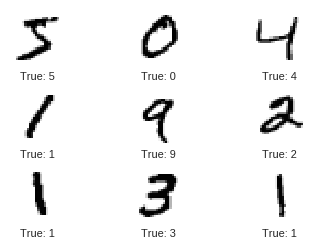

In [8]:
# Get the first images from the test-set
images = X_train[0:9]

# Get the true classes for those images
cls_true = y_train[0:9]

# Plot the images and labels using our helper-function above
plot_images(images=images, cls_true=cls_true)

**Tensorflow Graph**

A TensorFlow graph consists of the following parts which will be detailed below:

  1. Placeholder variables used for inputting    data to the graph.
  2. Variables that are going to be optimized so as to make the convolutional network perform better.
  3. The mathematical formulas for the convolutional network.
  4. A cost measure that can be used to guide the optimization of the variables.
  5. An optimization method which updates the variables.






**Helper functions for creating new Variable**

In [0]:
def new_weights(shape):
  return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [0]:
def new_biases(length):
  return tf.Variable(tf.constant(0.05, shape=[length]))

**Helper function for creating a new Convolutional Layer**

This function creates a new convolutional layer in the computational graph for Tensorflow

It is assumed that the input is a 4-d tensor with following dimensions -:

1.   Image number
2.   Y-axis of each image
3.   X-axis of each image
4.   Channels of each image

Note -: Input channels may either be color-channels, or it may be filter-channels if the input is produced from a previous convolutional layer.

The output is another 4-d tensor with the following dimensions -:

1.   Image number, same as input
2.   Y-axis of each image. h and w reduces by 2 if 2x2 pooling is used
3.   X-axis of each image. same
4.   Channels produced by the convolutional filters





In [0]:
def new_conv_layer(input:'input from previous layer',
                  num_input_channels:'Num of channels in previous layer',
                  filter_size:'Width and height of each filter',
                  num_filters:'Number of filters',
                  use_pooling:'Use 2x2 max-pooling'=True)->'returns both resulting layer and filter-weights':
  
  # Shape of the filter weights of the convolution
  shape = [filter_size, filter_size, num_input_channels, num_filters]
  
  # Create new weights of filters
  weights = new_weights(shape=shape)
  
  # Create new biases, one for each filter
  biases = new_biases(length=num_filters)
  
  '''
    * Create tensorflow operation for convolution
    * Strides are set to 1
    * First and last stride must always be 1
    * First is for image number and last is for input-channel
    * [1,2,2,1] stride means filter is moved 2 pixels along x&y axis
    * Padding is set 'same'
  '''
  
  layer = tf.nn.conv2d(input = input,
                      filter = weights,
                      strides = [1,1,1,1],
                      padding = 'SAME')
  
  # Add the biases to the results of the convolution.
  # A bias-value is added to each filter-channel.
  layer += biases
  
  if use_pooling:
    layer = tf.nn.max_pool(value=layer,
                          ksize=[1,2,2,1],
                          strides=[1,2,2,1],
                          padding='SAME')
    
  layer = tf.nn.relu(layer)
  
  return layer, weights
  
  

**Helper-function for flattening a layer**

In [0]:
def flatten_layer(layer):
  layer_shape = layer.get_shape()
  # layer_shape = [num_images, img_height, img_width, num_channels]
  num_features = layer_shape[1:4].num_elements()
  # num of features is : img_height * img_width * num_channels
  
  layer_flat = tf.reshape(layer, [-1,num_features])
  # Reshape the layer to [num_images, num_features]
  # The shape of The flattened layer is now:
  # [num_images, img_height * img_width * num_channels]
  # Return both flattened layer and the number of features
  return layer_flat, num_features

**Helper function for creating a fully connected layer**

In [0]:
def new_fc_layer(input:'The previous layer',
                 num_inputs:'Num. inputs fro prev layer',
                 num_outputs:'Num outputs',
                 use_relu:'Use Rectified Linear Unit (ReLU)'=True):
  # Create new weights and biases
  weights = new_weights(shape=[num_inputs,num_outputs])
  biases = new_biases(length=num_outputs)
  
  # Calculate layer as mat mul of inputs&weights and add biases
  layer = tf.matmul(input, weights) + biases
  
  # Use ReLU
  if use_relu:
    layer = tf.nn.relu(layer)
    
  return layer

**Placeholder variables**

Placeholder vaeiables serve as the input the Tensorflow computational graph that we may change each time we execute the graph

In [0]:
x = tf.placeholder(tf.float32, shape=[None, img_flat_size], name='x')

The convolutional layers expect x to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead [num_images, img_height, img_width, num_channels]. Note that img_height == img_width == img_size and num_images can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [0]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.

In [0]:
y_true = tf.placeholder(tf.float32, shape=[None, len(num_classes)], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point

In [0]:
y_true_cls = tf.argmax(y_true, axis=1)

**Convolutional Layer1**

In [18]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                           num_input_channels=num_channels,
                                           filter_size=filter_size1,
                                           num_filters=n_filters1,
                                           use_pooling=True)

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

**Convolutional Layer 2**

Create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer.

In [0]:
layer_conv2, weights = \
  new_conv_layer(input=layer_conv1,
                num_input_channels=n_filters1,
                filter_size = filter_size2,
                num_filters = n_filters2,
                use_pooling=True)

In [21]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

**Flatten Layer**

The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors

In [0]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [23]:
layer_flat # shape 7 * 7 * 36

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

**Fully Connected Layer 1**

Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is fc_size. ReLU is used so we can learn non-linear relations.

In [0]:
layer_fc1 = new_fc_layer(input=layer_flat,
                        num_inputs=num_features,
                        num_outputs=f_size,
                        use_relu=True)

In [25]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

**Fully-Connected Layer 2**

Add another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer.

In [0]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=f_size,
                         num_outputs=len(num_classes),
                         use_relu=False)

In [27]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

**Predicted Class**

The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in y_pred.

In [0]:
y_pred = tf.nn.softmax(layer_fc2)

In [0]:
y_pred_cls = tf.argmax(y_pred, axis=1)

**Cost-function to be optimized**

To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.

TensorFlow has a built-in function for calculating the cross-entropy. Note that the function calculates the softmax internally so we must use the output of layer_fc2 directly rather than y_pred which has already had the softmax applied.

In [30]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
cost = tf.reduce_mean(cross_entropy)

**Optimisation Method**

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the AdamOptimizer which is an advanced form of Gradient Descent.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

**Performance Measures**

We need a few more performance measures to display the progress to the user.

This is a vector of booleans whether the predicted class equals the true class of each image.

In [0]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers

In [0]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**Running The Tensorflow**

**Create Tensorflow Session**

In [0]:
session = tf.Session()

**Initialize Variables**

The variables for weights and biases must be initialized before we start optimizing them.

In [0]:
session.run(tf.global_variables_initializer())

**Helper-function to perform optimization iterations**

In [0]:
train_batch_size = 64

In [0]:
# Helper function for getting batch size
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [0]:
total_iterations = 0

def optimize(num_iterations):
  # Ensure we update the global variable rather than local copy
  global total_iterations
  
  # Start-time used for printing time_usage below
  start_time = time.time()
  
  for i in range(total_iterations,
                 total_iterations + num_iterations):
    
    x_batch, y_true_batch = next_batch(num=train_batch_size,
                                          data = X_train,
                                          labels = y_train)
    
    feed_dict_train = { x : x_batch.reshape(-1,784),
                        y_true : np.eye(len(num_classes))[y_true_batch] }
    
    # Run the optimizer using this batch training data
    session.run(optimizer, feed_dict=feed_dict_train)
    
    # Print status every 100 iterations.
    
    if i % 100 == 0:
      # Calculate the accuracy
      acc = session.run(accuracy, feed_dict=feed_dict_train)
      
      msg = 'Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}'
      print(msg.format(i+1, acc))
    
  total_iterations += num_iterations
  
  end_time = time.time()
  
  time_dif = end_time - start_time
  
  print('Time-Usage' + str(timedelta(seconds=int(round(time_dif)))))

In [0]:
# Helper function to plot example errors

def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [0]:
# Helper function to plot confusion matrix


def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = y_test
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(len(num_classes))
    plt.xticks(tick_marks, range(len(num_classes)))
    plt.yticks(tick_marks, range(len(num_classes)))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
# Helper function for showing performance


# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = X_test.shape[0]

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = X_test[i:j, :].reshape(-1,784)

        # Get the associated labels.
        labels = np.eye(len(num_classes))[y_test[i:j]]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = y_test

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [43]:
# Performance before any optimisation

print_test_accuracy()

Accuracy on Test-Set: 10.8% (1078 / 10000)


In [44]:
# Performance after 1 optimisation iteration
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  10.9%
Time-Usage0:00:00


In [45]:
print_test_accuracy()

Accuracy on Test-Set: 12.4% (1237 / 10000)


In [46]:
#Performance after 100 optimisation iterations
optimize(num_iterations=99)

Time-Usage0:00:01


Accuracy on Test-Set: 81.9% (8191 / 10000)
Example errors:


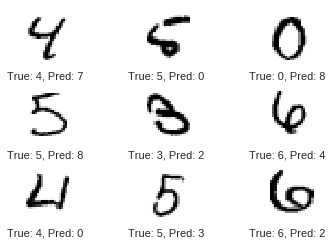

In [47]:
print_test_accuracy(show_example_errors=True)

In [48]:
#performance after 1000 optimization iterations
optimize(num_iterations=900)

Optimization Iteration:    101, Training Accuracy:  84.4%
Optimization Iteration:    201, Training Accuracy:  93.8%
Optimization Iteration:    301, Training Accuracy:  92.2%
Optimization Iteration:    401, Training Accuracy:  92.2%
Optimization Iteration:    501, Training Accuracy:  95.3%
Optimization Iteration:    601, Training Accuracy:  92.2%
Optimization Iteration:    701, Training Accuracy:  95.3%
Optimization Iteration:    801, Training Accuracy:  95.3%
Optimization Iteration:    901, Training Accuracy:  98.4%
Time-Usage0:00:07


Accuracy on Test-Set: 95.9% (9588 / 10000)
Example errors:


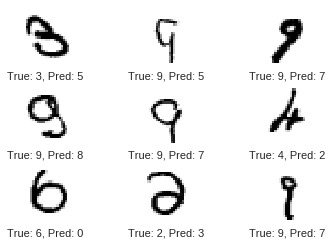

In [49]:
print_test_accuracy(show_example_errors=True)

In [50]:
#performance after 10,000 optimization iterations
optimize(num_iterations=9000)

Optimization Iteration:   1001, Training Accuracy:  95.3%
Optimization Iteration:   1101, Training Accuracy:  95.3%
Optimization Iteration:   1201, Training Accuracy:  98.4%
Optimization Iteration:   1301, Training Accuracy:  96.9%
Optimization Iteration:   1401, Training Accuracy:  98.4%
Optimization Iteration:   1501, Training Accuracy:  98.4%
Optimization Iteration:   1601, Training Accuracy:  98.4%
Optimization Iteration:   1701, Training Accuracy: 100.0%
Optimization Iteration:   1801, Training Accuracy:  98.4%
Optimization Iteration:   1901, Training Accuracy:  93.8%
Optimization Iteration:   2001, Training Accuracy:  96.9%
Optimization Iteration:   2101, Training Accuracy:  98.4%
Optimization Iteration:   2201, Training Accuracy:  95.3%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy: 100.0%
Optimization Iteration:   2501, Training Accuracy: 100.0%
Optimization Iteration:   2601, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 98.8% (9880 / 10000)
Example errors:


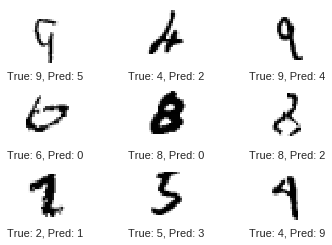

Confusion Matrix:
[[ 978    0    1    0    0    0    0    0    1    0]
 [   0 1133    0    0    0    0    2    0    0    0]
 [   3    3 1017    2    1    0    0    4    2    0]
 [   0    0    1 1004    0    2    0    1    2    0]
 [   1    0    1    0  976    0    1    0    1    2]
 [   0    1    0    6    0  882    1    0    0    2]
 [   7    2    0    1    3    6  939    0    0    0]
 [   0    3    1    1    1    0    0 1015    2    5]
 [   4    1    1    3    3    3    0    2  954    3]
 [   3    0    0    3   14    4    0    2    1  982]]


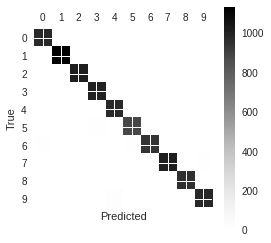

In [51]:
print_test_accuracy(show_confusion_matrix=True,
                    show_example_errors=True)